# Проект №3 EDA + Feature Engineering Booking.com

### Какой кейс решаем?
Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

### Наименование столбцов:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

### Файлы для соревнования

* hotels_train.csv - набор данных для обучения [источник данных](https://github.com/slagovskiy/DST/raw/main/Project-3/data/hotels_train.csv.zip)
* hotels_test.csv - набор данных для оценки качества [источник данных](https://github.com/slagovskiy/DST/raw/main/Project-3/data/hotels_train.csv.zip)
* submission.csv - файл сабмишна в нужном формате [источник данных](https://github.com/slagovskiy/DST/raw/main/Project-3/data/hotels_train.csv.zip)


## 1. Исходные данные

In [1]:
!pip install Afinn
!pip install nltk

import numpy as np
import pandas as pd
import category_encoders as ce

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import re
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from textblob import TextBlob, Blobber
# from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn

nltk.download('vader_lexicon', download_dir='.')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 205.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for Afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=8769c1a5123bffded0dbe856332531b18bcb5153bddf3b5f847e6ea2d06d2b3f
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built Afinn


[nltk_data] Downloading package vader_lexicon to ....


/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [1]:
RANDOM_SEED = 42

In [3]:
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR + 'hotels_train.csv')
df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'submission.csv')
# local test only
# DATA_DIR = 'data'
# df_train = pd.read_csv(DATA_DIR + '/hotels_train.csv.zip')
# df_test = pd.read_csv(DATA_DIR + '/hotels_test.csv.zip')
# sample_submission = pd.read_csv(DATA_DIR + '/submission.csv.zip')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
dupl_columns = list(df_train.columns)

mask_d = df_train.duplicated(subset=dupl_columns)
df_train_duplicates = df_train[mask_d]

df_train = df_train.drop_duplicates(subset=dupl_columns)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 

In [6]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.508,-0.144
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521,-0.123
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845,2.326
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,11,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,48.889,2.395
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,20,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,52.386,4.847


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.100,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533,9.171
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.600,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.386,4.834
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.300,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,41.393,2.162
3,Piazza Della Repubblica 17 Central Station 20124 Milan Italy,241,10/17/2015,9.100,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hotel has been revamped and what a surprise Love every second of it including in room dining which was excellent,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Junior Suite ', ' Stayed 1 night ']",656 day,45.480,9.196
4,Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands,834,5/16/2016,9.100,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Classic Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",444 day,52.371,4.889


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [10]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


Для обработки признаков сольем тренировочный и тестовый датасет в один, для разделения добавим общий признак sample, который будет равен 1 для тренировочных данных и 0 для тестовых. Так же в тестовом датасете создадим целевой признак reviewer_score и заполним его нулями.

In [11]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

hotels = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

In [12]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [13]:
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.508,-0.144,1
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521,-0.123,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845,2.326,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,11,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,48.889,2.395,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,20,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,52.386,4.847,1


In [14]:
hotels.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
reviewer_score                                    38
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
dtype: int64

## 2. Проектирование признаков

Выделим признаки с пропусками в данных

In [15]:
hotels_nulls = hotels.isnull().sum()
display(hotels_nulls[hotels_nulls > 0])

lat    3268
lng    3268
dtype: int64

В признаках lat и lng есть пропуски в данных, это географические координаты, нет смысла подбирать какие то осознанные замены для этих данных, по этому заполним пропуски нулями.

In [16]:
hotels['lat'] = hotels['lat'].fillna(0, inplace=True)
hotels['lng'] = hotels['lng'].fillna(0, inplace=True)

### 2.1 Название отеля

Первоначально получим количество уникальных отелей по названиям.

In [17]:
hotels['hotel_name'].nunique()

1492

Выделим отели под одинаковым названием, но с различным адресом и добавим, для уникальности, к названию часть адреса.

In [18]:
address_list = hotels.pivot_table(
    values = 'hotel_address',
    index = 'hotel_name',
    aggfunc = 'nunique'
)
dupl_hotel = address_list[address_list['hotel_address'] > 1]
display(dupl_hotel)
_temp_list = dupl_hotel[dupl_hotel['hotel_address'] > 1].index.to_list() # через временную переменную быстрее обрабатывается
hotels['hotel_name'] = hotels.apply(lambda x: (x['hotel_name'] + ' in ' + x['hotel_address'].split()[-1])
    if (x['hotel_name'] in _temp_list) else x['hotel_name'], axis=1)
display(hotels['hotel_name'].nunique())

,hotel_address
hotel_name,
Hotel Regina,3


1494

Окончательно получили 1494 уникальных отеля.

### 2.2 Адрес отеля

Из признака hotel_address, извлечём: страну и город.

In [19]:
hotels['hotel_address'].head(20)

0       Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
1                   130 134 Southampton Row Camden London WC1B 5AF United Kingdom
2                                151 bis Rue de Rennes 6th arr 75006 Paris France
3                              216 Avenue Jean Jaures 19th arr 75019 Paris France
4                                       Molenwerf 1 1014 AG Amsterdam Netherlands
5                                              Via Mecenate 121 20138 Milan Italy
6           97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom
7                               Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
8           190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom
9        Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom
10                                      Molenwerf 1 1014 AG Amsterdam Netherlands
11    34 44 Barkston Gardens Kensington and Chelsea London SW5 0EW United Kingdom
12           16 

In [20]:
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])
hotels['hotel_country'] = hotels['hotel_country'].apply(lambda x:'United Kingdom' if x == 'Kingdom' else x)
country_list = list(hotels['hotel_country'].unique())
display(country_list)

['United Kingdom', 'France', 'Netherlands', 'Italy', 'Austria', 'Spain']

Выделено 6 уникальных стран.

In [21]:
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-2])
hotels['hotel_city'] = hotels['hotel_city'].apply(lambda x: 'London' if x == 'United' else x)
city_list = list(hotels['hotel_city'].unique())
display(city_list)

['London', 'Paris', 'Amsterdam', 'Milan', 'Vienna', 'Barcelona']

Так же получено 6 унимальных городов.
В каждой стране представлен только один город, по этому кодировать признак города не имеет смысла, кодируем страну и создаем новый признак.

In [22]:
hotels['hotel_country_code'] = hotels['hotel_country'].astype('category').cat.codes
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample,hotel_country,hotel_city,hotel_country_code
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,None,None,1,United Kingdom,London,5
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,None,None,1,United Kingdom,London,5
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,None,None,1,France,Paris,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,...,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,None,None,1,France,Paris,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,...,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,None,None,1,Netherlands,Amsterdam,3


### 2.3 Географические координаты.

Несмотря на то, что данные представлены в числовом виде правильнее их рассматривать как категориальные. Можно постараться сделать расчеты до центра города, или до ближайших станций метро или же до каких то достопримечательностей, но по моему проще избавиться от этих признаков. Если результат нас не удовлетворит, то вернемся к этому моменту.

In [23]:
hotels = hotels.drop(['lat', 'lng'], axis=1)
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,sample,hotel_country,hotel_city,hotel_country_code
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,1,United Kingdom,London,5
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,1,United Kingdom,London,5
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,1,France,Paris,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,11,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,1,France,Paris,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,20,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,1,Netherlands,Amsterdam,3


### 2.4 Тэги

Количество тэгов.

In [24]:
hotels['tags_count'] = hotels['tags'].apply(lambda x: len(re.findall("'[^\'](.+?)[^\']'", x)))
hotels['tags_count'].head(2)

0    5
1    4
Name: tags_count, dtype: int64

Создадим новые признаки на основании тегов.

In [25]:
def get_tags(tags_string):
    tags_string = tags_string.replace('[', '').replace(']', '')
    tags_string = tags_string.replace("' ", '').replace(" '", '')
    tags_list = tags_string.split(',')
    tags_list = list(map(lambda x: x.strip(), tags_list))

    reviewer_types = {
        'Solo traveler': 1,
        'Couple': 2,
        'Travelers with friends': 3,
        'Family with young children': 4,
        'Family with older children': 5,
        'Group': 6
    }

    room_types = {
            'without Window': 0,
            'Guestroom': 1,
            'Classic': 2,
            'Single': 3,
            'Standard': 4,
            'Superior': 5,
            'Comfort': 6,
            'Club': 7,
            'Suite': 8,
            'Deluxe': 9,
            'King': 10,
            'Premier': 11
            # 'Double'        # 12
            # 'Other'         # 13
        }


    tag_from_mobile = 0
    tag_with_pet = 0
    tag_leisure_trip = 1
    tag_reviewer_type = 0
    tag_count_nights = 0
    tag_view_room = 0
    tag_room_type = -1

    for _tag in list(tags_list):
        if _tag == 'Submitted from a mobile device':
            tag_from_mobile = 1
            tags_list.remove(_tag)

        if _tag == 'With a pet':
            tag_with_pet = 1
            tags_list.remove(_tag)

        if _tag == 'Business trip':
            tag_leisure_trip = 0
            tags_list.remove(_tag)

        if _tag == 'Leisure trip':
            tag_leisure_trip = 1
            tags_list.remove(_tag)

        if _tag in reviewer_types.keys():
            tag_reviewer_type = reviewer_types[_tag]
            tags_list.remove(_tag)

        if re.fullmatch(r'Stayed\s\d+\snight\w?', _tag):
            tag_count_nights = [float(s) for s in re.findall(r'-?\d+\.?\d*', _tag)][0]
            tags_list.remove(_tag)

        if len(tags_list) > 0:
            if ('View' in tags_list[0]) | ('Panoramic' in tags_list[0]):
                tag_view_room = 1

            for rt in room_types.keys():
                if rt in tags_list[0]:
                    tag_room_type = room_types[rt]

            if 'Double' in tags_list[0] or 'Twin' in tags_list[0]:
                tag_room_type = 12
            if tag_room_type == -1:
                tag_room_type = 13

    return tag_from_mobile, tag_with_pet, tag_leisure_trip, tag_reviewer_type, tag_count_nights, tag_view_room, tag_room_type

hotels[['tag_from_mobile',    # отправлено с мобильного
        'tag_with_pet',       # путешествие с домашними животными
        'tag_leisure_trip',   # путешествие по работе / отдых
        'tag_reviewer_type',  # тип путешествия
        'tag_count_nights',   # количество ночей
        'tag_view_room',      # номер с видом на ...
        'tag_room_type'       # тип номера
        ]
] = pd.DataFrame(hotels['tags'].apply(get_tags).to_list(), index=hotels.index)

In [26]:
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,hotel_city,hotel_country_code,tags_count,tag_from_mobile,tag_with_pet,tag_leisure_trip,tag_reviewer_type,tag_count_nights,tag_view_room,tag_room_type
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,London,5,5,1,0,1,2,2.000,0,8
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,London,5,4,0,0,0,2,1.000,0,12
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,Paris,1,5,1,0,1,1,3.000,0,12
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,...,Paris,1,4,0,0,1,1,1.000,0,12
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,...,Amsterdam,3,4,0,0,0,2,6.000,0,12


### 2.5 Дата отзыва

Выделим из даты отзыва месяц.

In [27]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_month'] = hotels['review_date'].dt.month

Выделим день недели

In [28]:
hotels['day_of_week'] = hotels['review_date'].dt.dayofweek

Выделим месяцы "высокого" сезона.

In [29]:
display(hotels['review_month'].value_counts())

8     50632
7     49291
5     46470
10    43803
6     42877
4     42872
9     42369
1     42133
3     41090
12    39591
2     38352
11    35951
Name: review_month, dtype: int64

Выделим топ 4, дальше разброс не сильно большой.

In [30]:
hotels['high_season'] = hotels['review_month'].apply(lambda x: 1 if x in [8,7,5,10] else 0)

Заменим признак days_since_review на числовой.

In [31]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: np.float64(re.findall(r'\d+', x)[0])).convert_dtypes()

Общее количество отзывов

In [32]:
hotels['total_number_of_reviews_reviewer_has_given'].groupby(pd.cut(hotels['total_number_of_reviews_reviewer_has_given'], np.arange(0, 500, 50))).agg('count')
hotels['total_number_of_reviews_reviewer_has_given'] = hotels['total_number_of_reviews_reviewer_has_given'].apply(lambda x: np.log(x+1))

In [33]:
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tag_from_mobile,tag_with_pet,tag_leisure_trip,tag_reviewer_type,tag_count_nights,tag_view_room,tag_room_type,review_month,day_of_week,high_season
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2016-02-19,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,1,0,1,2,2.000,0,8,2,4,0
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,2017-01-12,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,0,0,0,2,1.000,0,12,1,3,0
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,1,0,1,1,3.000,0,12,10,1,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,2015-09-22,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,...,0,0,1,1,1.000,0,12,9,1,0
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,...,0,0,0,2,6.000,0,12,3,5,0


### 2.6 Отзывы

 Отзывы и их структура поможет разобраться в поставленной задаче лучше всего. Для этого надо изучить отзывы, выделить эмоциональную окраску: негативная, нейтральная, позитивная.

Участники соревнования активно применяют библиотеку VADER, класс SentimentIntensityAnalyzer, не будем от них отставать.

In [34]:
# Создаём объекты SentimentIntensityAnalyzer
positive = SentimentIntensityAnalyzer()
negative = SentimentIntensityAnalyzer()

# посмотрим как изменится характеристика слова 'nothing':
example = 'nothing'
print(f'Словарь оценок слова "{example}" до преобразований:')
print(negative.polarity_scores(example), '\n')

# добавим контекст:
negative_words = {'small': -1, 'nothing': 10}
positive_words = {'nothing': -10, 'everything': 10}
negative.lexicon.update(negative_words)
positive.lexicon.update(positive_words)

print(f' - после преобразований (для негативного контекста):')
print(negative.polarity_scores(example))
print(f' - после преобразований (для позитивного контекста):')
print(positive.polarity_scores(example))

# фразы "No Negative" тонально будет нести негативную окраску:
example = 'No Negative'
print(f'\nСловарь оценок фразы "{example}":')
print(negative.polarity_scores(example))
example = 'Positive'
print(f'Словарь оценок фразы "{example}":')
print(negative.polarity_scores(example))

# меняем метки отсутствия частей отзыва:
hotels['negative_review_temp'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
hotels['positive_review_temp'] = hotels['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
hotels['positive_review_temp'] = hotels['negative_review'].apply(lambda x: x.replace('All good', 'Positive'))
hotels['positive_review_temp'] = hotels['negative_review'].apply(lambda x: x.replace('No complaints', 'Positive'))
hotels['positive_review_temp'] = hotels['negative_review'].apply(lambda x: x.replace('Nothing to dislike', 'Positive'))
hotels['positive_review_temp'] = hotels['positive_review'].apply(lambda x: x.replace('No Positive', 'Negative'))

Словарь оценок слова "nothing" до преобразований:
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} 

 - после преобразований (для негативного контекста):
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.9325}
 - после преобразований (для позитивного контекста):
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.9325}

Словарь оценок фразы "No Negative":
{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}
Словарь оценок фразы "Positive":
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5574}


In [35]:
%%time

hotels['negative_review_sentiments'] = hotels['negative_review_temp'].apply(lambda x: negative.polarity_scores(x))

hotels['positive_review_sentiments'] = hotels['positive_review_temp'].apply(lambda x: positive.polarity_scores(x))

# формируем новые признаки:
hotels['neg_review_sentiments_neg'] = hotels['negative_review_sentiments'].apply(lambda x: x['neg'])
hotels['neg_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(lambda x: x['neu'])
hotels['neg_review_sentiments_pos'] = hotels['negative_review_sentiments'].apply(lambda x: x['pos'])
hotels['neg_review_sentiments_compound'] = hotels['negative_review_sentiments'].apply(lambda x: x['compound'])

hotels['pos_review_sentiments_neg'] = hotels['positive_review_sentiments'].apply(lambda x: x['neg'])
hotels['pos_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(lambda x: x['neu'])
hotels['pos_review_sentiments_pos'] = hotels['positive_review_sentiments'].apply(lambda x: x['pos'])
hotels['pos_review_sentiments_compound'] = hotels['positive_review_sentiments'].apply(lambda x: x['compound'])

CPU times: user 4min 30s, sys: 769 ms, total: 4min 31s
Wall time: 4min 31s


## 3. Отбор призаков

### 3.1 Очистка дата-сета от ненужных вспомогательных признаков

In [36]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   hotel_name                                  515431 non-null  object        
 5   reviewer_nationality                        515431 non-null  object        
 6   negative_review                             515431 non-null  object        
 7   review_total_negative_word_counts           515431 non-null  int64         
 8   total_number_of_reviews                     515431 non-null  int64        

In [37]:
hotels_copy = hotels.copy()

In [38]:
object_columns = [s for s in hotels_copy.columns if hotels_copy[s].dtypes == 'object']
hotels_copy.drop(object_columns, axis = 1, inplace=True)

In [39]:
hotels_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515431 non-null  int64         
 1   review_date                                 515431 non-null  datetime64[ns]
 2   average_score                               515431 non-null  float64       
 3   review_total_negative_word_counts           515431 non-null  int64         
 4   total_number_of_reviews                     515431 non-null  int64         
 5   review_total_positive_word_counts           515431 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  float64       
 7   reviewer_score                              515431 non-null  float64       
 8   days_since_review                           515431 non-null  Int64        

In [40]:
cat_date_columns = [cd for cd in hotels_copy.columns if ((hotels_copy[cd].dtypes.name == 'category') or (hotels_copy[cd].dtypes == 'datetime64[ns]'))]
hotels_copy.drop(cat_date_columns, axis = 1, inplace=True)

In [41]:
hotels_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  float64
 6   reviewer_score                              515431 non-null  float64
 7   days_since_review                           515431 non-null  Int64  
 8   sample                                      515431 non-null  int64  
 9   hotel_country_code                          515431 non-null  int8   
 

### 3.2 Анализ мультиколлинеарности

In [42]:
cols_num = [
    'review_total_negative_word_counts',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'tags_count',
    'tag_count_nights',
    'neg_review_sentiments_neg',
    'neg_review_sentiments_neu',
    'neg_review_sentiments_pos',
    'neg_review_sentiments_compound',
    'pos_review_sentiments_neg',
    'pos_review_sentiments_neu',
    'pos_review_sentiments_pos',
    'pos_review_sentiments_compound'
]

cols_cat = [
    'additional_number_of_scoring',
    'average_score',
    'total_number_of_reviews',
    'days_since_review',
    'hotel_country_code',
    'reviewer_score',
    'tag_from_mobile',
    'tag_with_pet',
    'tag_leisure_trip',
    'tag_reviewer_type',
    'tag_view_room',
    'tag_room_type',
    'review_month',
    'day_of_week',
    'high_season',
    'review_month',
]

In [43]:
def show_corr_heatmap(columns_list, title, method):
    fig_, ax_ = plt.subplots(figsize=(15, 12))
    corr = hotels_copy[columns_list].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr,
                annot=True,
                linewidths=0.1,
                ax=ax_,
                mask=mask,
                cmap='viridis',
                fmt='.1g')
    ax_.set_title(title, fontsize=18)
    plt.show()

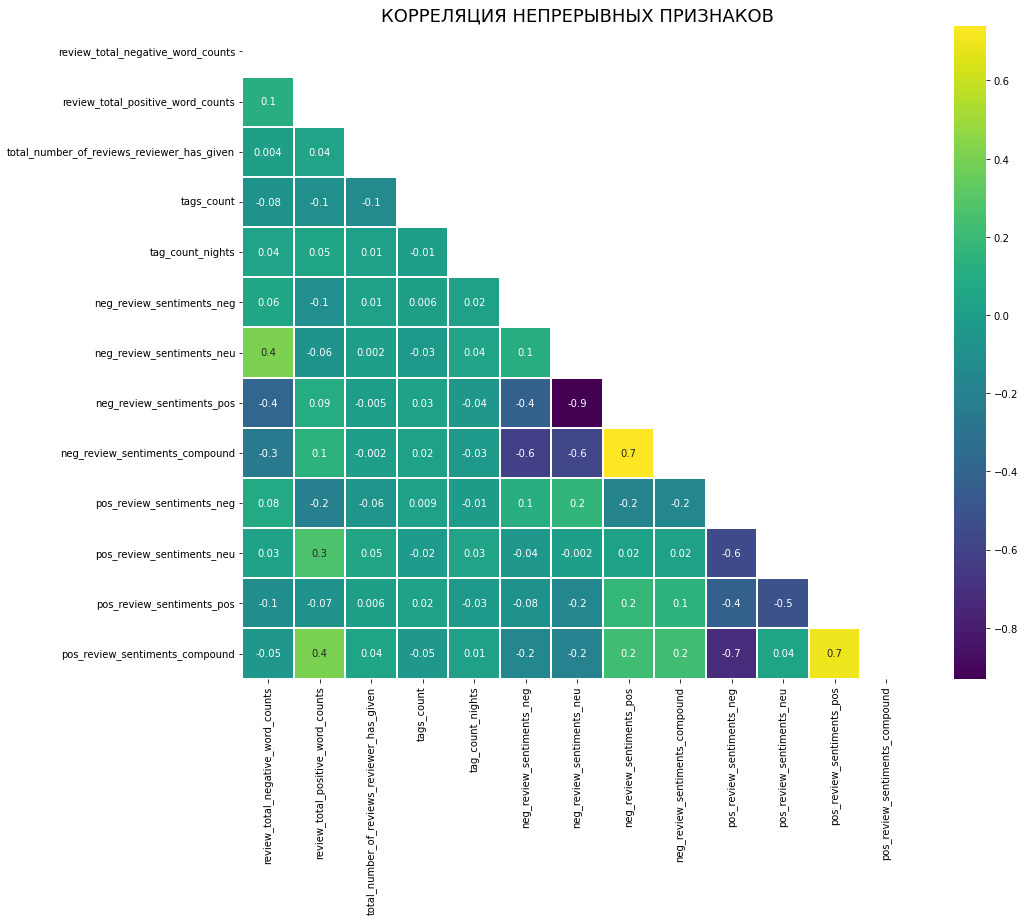

In [44]:
show_corr_heatmap(cols_num, 'КОРРЕЛЯЦИЯ НЕПРЕРЫВНЫХ ПРИЗНАКОВ', method='pearson')

In [45]:
drop_columns = ['neg_review_sentiments_pos']

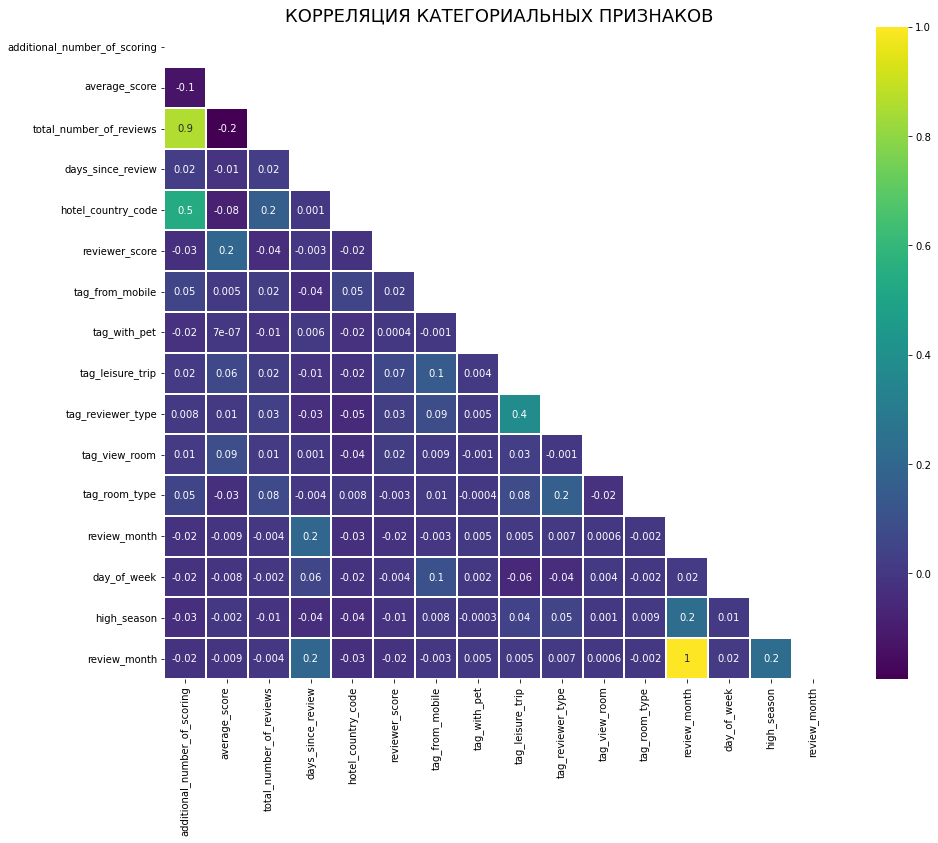

In [46]:
show_corr_heatmap(cols_cat, 'КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ', method='spearman');

In [47]:
drop_columns += ['review_month']

In [48]:
hotels_copy.drop(drop_columns, axis = 1, inplace=True)

In [49]:
hotels_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  int64  
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  float64
 6   reviewer_score                              515431 non-null  float64
 7   days_since_review                           515431 non-null  Int64  
 8   sample                                      515431 non-null  int64  
 9   hotel_country_code                          515431 non-null  int8   
 

### 3.3 Оценка значимости признаков

Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

<AxesSubplot:>

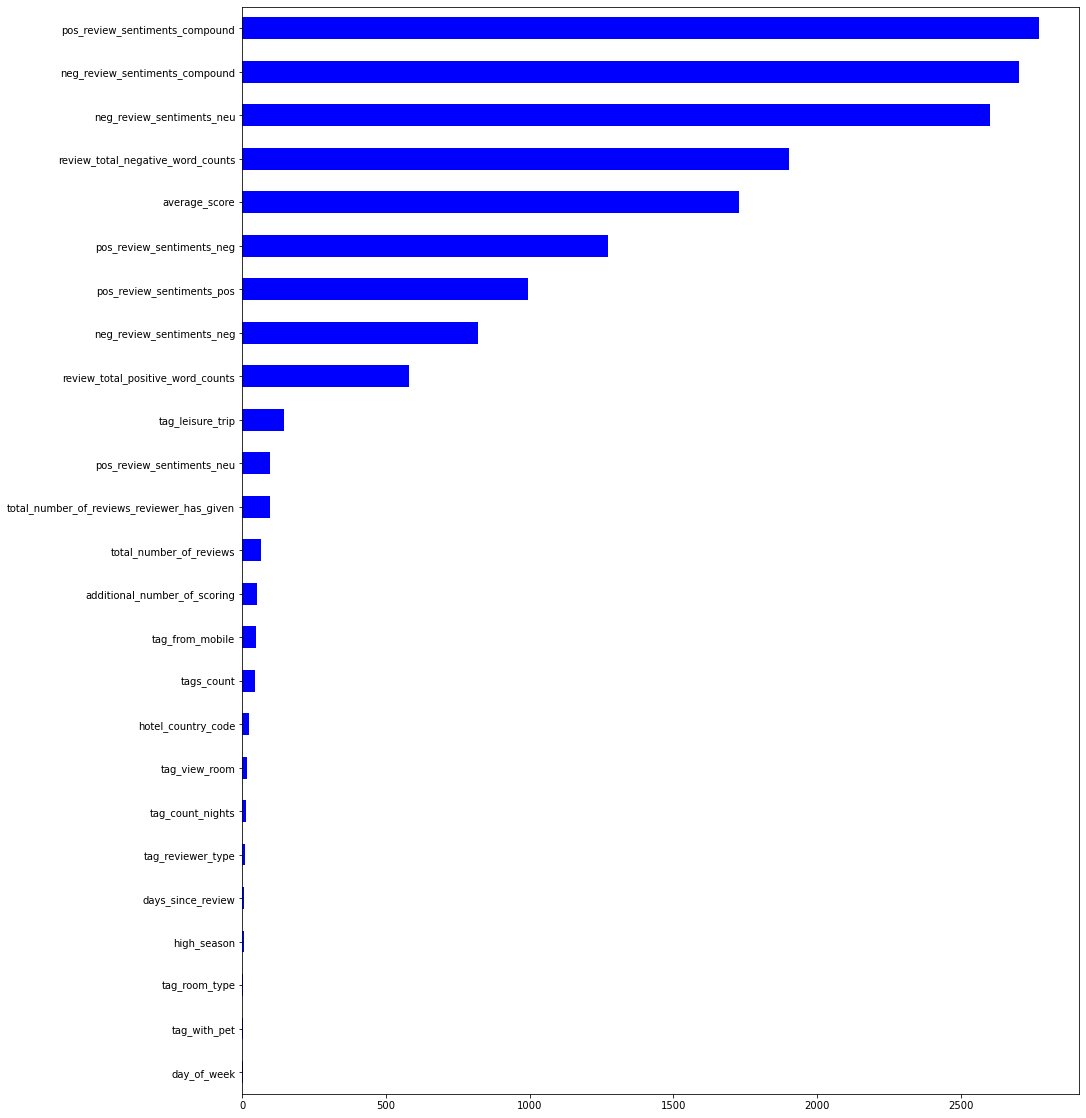

In [50]:
y = hotels_copy.query('sample == 1').drop(['sample'], axis=1)['reviewer_score'].values
X = hotels_copy.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp_num = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp_num.sort_values(inplace = True)

fig5, ax5 = plt.subplots(figsize=(15, 20))
imp_num.plot(kind = 'barh', color='blue')

In [51]:
imp_num

day_of_week                                     1.831
tag_with_pet                                    1.987
tag_room_type                                   3.422
high_season                                     5.900
days_since_review                               7.372
tag_reviewer_type                               9.781
tag_count_nights                               12.899
tag_view_room                                  14.957
hotel_country_code                             23.687
tags_count                                     43.290
tag_from_mobile                                46.030
additional_number_of_scoring                   49.876
total_number_of_reviews                        63.455
total_number_of_reviews_reviewer_has_given     95.539
pos_review_sentiments_neu                      97.318
tag_leisure_trip                              145.655
review_total_positive_word_counts             581.651
neg_review_sentiments_neg                     821.749
pos_review_sentiments_pos   

In [52]:
drop_columns = imp_num[imp_num < 5].index.tolist()
drop_columns

['day_of_week', 'tag_with_pet', 'tag_room_type']

In [53]:
hotels_copy.drop(drop_columns, axis = 1, inplace=True)

## 4. Обучение модели и получение предсказания

Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [54]:
train_data = hotels_copy.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_copy.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 23), (386496, 23), (386496, 22), (309196, 22), (77300, 22))

In [55]:
model = RandomForestRegressor(
    n_estimators=100,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_SEED)

In [56]:
%%time

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s


CPU times: user 9min 20s, sys: 2.01 s, total: 9min 22s
Wall time: 2min 23s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [57]:
def mean_absolute_percentage_error(y_tr, y_pr):
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.09


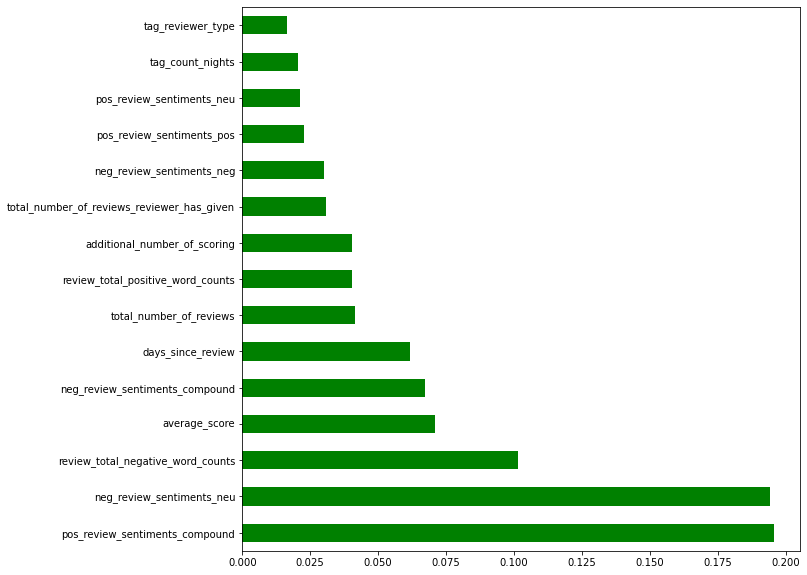

In [58]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='green');

Получаем предсказание целевой переменной

In [59]:
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = model.predict(test_data)
sample_submission['reviewer_score'] = predict_submission

#  сохраняем результат:
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


,reviewer_score,id
0,8.462,488440
1,7.123,274649
2,8.254,374688
3,9.807,404352
4,9.484,451596
5,8.728,302161
6,7.889,317079
7,7.967,13963
8,8.182,159785
9,7.495,195089
